In [2]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

# Experiment 0: preprocess data - code provided from Prof Kenytt Avery
# bank.csv from https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

bank = pd.read_csv('bank.csv', sep=';')

# Ordinal features
#
# Note: month probably shouldn't be ordinal.
# Then again, neither should day.

boolean = {'no': 0.0, 'yes': 1.0}
months = {
    'jan': 1.0, 'feb': 2.0, 'mar': 3.0, 'apr': 4.0,  'may': 5.0,  'jun': 6.0,
    'jul': 7.0, 'aug': 8.0, 'sep': 9.0, 'oct': 10.0, 'nov': 11.0, 'dec': 12.0
}

bank.replace({
    'default': boolean,
    'housing': boolean,
    'loan':    boolean,

    'month':   months,
    'y':       boolean
}, inplace=True)

# Categorical features
#
# Since we plan to use logistic regression, add drop_first=True
# to use dummy instead of one-hot encoding

categorical = ['job', 'marital', 'education', 'contact', 'poutcome']
bank = pd.get_dummies(bank, columns=categorical,
                      prefix=categorical, drop_first=True)

# Numeric features
#
# Standardized because we plan to use KNN and SVM

scaled = ['age', 'balance', 'day', 'month',
          'duration', 'campaign', 'pdays', 'previous']
bank[scaled] = sklearn.preprocessing.scale(bank[scaled].astype(float))

# Training set and targets
X = bank.drop(columns='y').values
t = bank['y'].values

Setup done by Professor Avery, note we added the random library for experiment 8.

## Experiment 1

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=0.2, shuffle=True, random_state=1)

## Experiment 2

In [4]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

## Experiment 3
#### a)

In [5]:
print('NB score: ', nb_clf.score(X_test, y_test))

NB score:  0.8


#### b)

In [6]:
y_pred = nb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[674 116]
 [ 65  50]]


#### c and d)

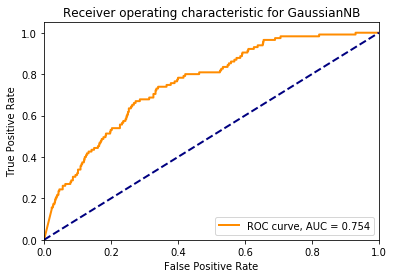

In [7]:
y_probs = nb_clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
auc = roc_auc_score(y_test, y_probs[:, 1])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label=f'ROC curve, AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for GaussianNB')
plt.legend(loc="lower right")
plt.show()

## Experiment 4

In [8]:
linreg_clf = LogisticRegression(fit_intercept=False, solver='lbfgs', random_state=1)
linreg_clf.fit(X_train, y_train)
print('linreg score: ', linreg_clf.score(X_test, y_test))

linreg score:  0.8806629834254144


## Experiment 5

In [9]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

svc_results = dict()
for kernel in kernels:
    svc = SVC(kernel=kernel, gamma='scale',
              random_state=1).fit(X_train, y_train)
    svc_results[kernel] = svc.score(X_test, y_test)

print('Best performing kernel: ', max(
    zip(svc_results.values(), svc_results.keys())))

print(svc_results.values())

Best performing kernel:  (0.881767955801105, 'rbf')
dict_values([0.8784530386740331, 0.8751381215469614, 0.881767955801105, 0.8486187845303867])


## Experiment 6

SVC performs best with score of ~ 0.8818

## Experiment 7

In [10]:
ones = 0
zeros = 0
for val in y_train:
    if val == 1:
        ones += 1
    else:
        zeros += 1

print(f'y_train contains {zeros} zeros and {ones} ones')
guess0Predict = zeros/(ones+zeros)
print("Accuracy: " + str(guess0Predict))

y_probs = np.full((len(y_train), 1), 0)

fpr, tpr, thresholds = roc_curve(y_train, y_probs)
auc = roc_auc_score(y_train, y_probs)
print("AUC: " + str(auc))

y_train contains 3210 zeros and 406 ones
Accuracy: 0.8877212389380531
AUC: 0.5


## Experiment 8

In [15]:
trueVals = []
falseVals = []
newVals = []

# Get values by their class and save
for i in range(len(y_train)):
    if y_train[i] == 1:
        trueVals.append(X_train[i])
    else:
        falseVals.append(X_train[i])

# Randomly pick data from old class 1 to make the size of class 0 and class 1 equal.      
newTrueVals = trueVals
while len(newTrueVals) < len(falseVals):
    newTrueVals.append(trueVals[(random.randint(0,len(trueVals)-1))])

# Reconstruct the data set
newTrueY = [1] * len(newTrueVals)
newFalseY = [0] * len(falseVals)

newX = newTrueVals + falseVals
newY = newTrueY + newFalseY

X_train, X_test, y_train, y_test = train_test_split(newX, newY, test_size=0.2, shuffle=True, random_state=1)

In [12]:
# Experiment 8-2
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

NB score:  0.6861370716510904
[[517 125]
 [278 364]]


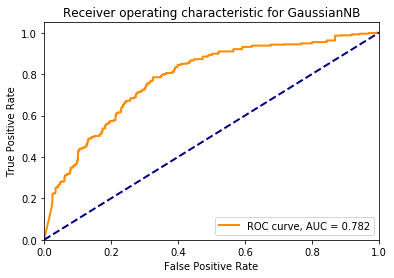

In [13]:
# Experiment 8-3
#
# a
print('NB score: ', nb_clf.score(X_test, y_test))

# b
y_pred = nb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# c, d
#
y_probs = nb_clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
auc = roc_auc_score(y_test, y_probs[:, 1])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label=f'ROC curve, AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for GaussianNB')
plt.legend(loc="lower right")
plt.show()

In [14]:
# Experiment 8-4
linreg_clf = LogisticRegression(
    fit_intercept=False, solver='lbfgs', random_state=1)
linreg_clf.fit(X_train, y_train)
print('linreg score: ', linreg_clf.score(X_test, y_test))

linreg score:  0.8021806853582555


In [15]:
# Experiment 8-5
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

svc_results = dict()
for kernel in kernels:
    svc = SVC(kernel=kernel, gamma='scale',
              random_state=1).fit(X_train, y_train)
    svc_results[kernel] = svc.score(X_test, y_test)

print('Best performing kernel: ', max(
    zip(svc_results.values(), svc_results.keys())))

print(svc_results.values())

Best performing kernel:  (0.8925233644859814, 'poly')
dict_values([0.7967289719626168, 0.8925233644859814, 0.8917445482866043, 0.7079439252336449])
